In [1]:
!pip install ultralytics --upgrade

In [1]:
from ultralytics import YOLO
from IPython.display import Image, display
import os, glob

from google.colab import drive

In [2]:
model = YOLO('/content/drive/MyDrive/Masters_AI_24/Pedestrian tracking/data/train18_best_model.pt')

In [5]:
!unzip '/content/drive/MyDrive/Masters_AI_24/Pedestrian tracking/data/MOT20Det.zip' -d /content/MOT20

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: /content/MOT20/MOT20Det/train/MOT20-05/img1/001749.jpg  
  inflating: /content/MOT20/MOT20Det/train/MOT20-05/img1/002678.jpg  
  inflating: /content/MOT20/MOT20Det/train/MOT20-05/img1/000191.jpg  
  inflating: /content/MOT20/MOT20Det/train/MOT20-05/img1/003108.jpg  
  inflating: /content/MOT20/MOT20Det/train/MOT20-05/img1/001639.jpg  
  inflating: /content/MOT20/MOT20Det/train/MOT20-05/img1/001889.jpg  
  inflating: /content/MOT20/MOT20Det/train/MOT20-05/img1/001945.jpg  
  inflating: /content/MOT20/MOT20Det/train/MOT20-05/img1/000828.jpg  
  inflating: /content/MOT20/MOT20Det/train/MOT20-05/img1/001705.jpg  
  inflating: /content/MOT20/MOT20Det/train/MOT20-05/img1/001464.jpg  
  inflating: /content/MOT20/MOT20Det/train/MOT20-05/img1/000252.jpg  
  inflating: /content/MOT20/MOT20Det/train/MOT20-05/img1/002793.jpg  
  inflating: /content/MOT20/MOT20Det/train/MOT20-05/img1/001323.jpg  
  inflating: /content/

Склеиваем кадры в mp4

In [3]:
import cv2
from natsort import natsorted

In [7]:
for train_video_id in [1, 2, 3, 5]:
    frame_folder = f'/content/MOT20/MOT20Det/train/MOT20-0{train_video_id}/img1'
    img_paths = natsorted(glob.glob(f'{frame_folder}/*.jpg'))

    if not img_paths:
        print(f'{frame_folder} is empty')
        continue

    frame = cv2.imread(img_paths[0])
    h, w, _ = frame.shape

    video_path = f'/content/MOT20-0{train_video_id}.mp4'
    out = cv2.VideoWriter(video_path, cv2.VideoWriter_fourcc(*'mp4v'), 25, (w, h))

    for path in img_paths:
        frame = cv2.imread(path)
        out.write(frame)

    out.release()
    print(f'Saved {train_video_id}: {video_path}')


Saved 1: /content/MOT20-01.mp4
Saved 2: /content/MOT20-02.mp4
Saved 3: /content/MOT20-03.mp4
Saved 5: /content/MOT20-05.mp4


Запускаем трекинг обученной моделью.

В labels получим:
- class,
- x_center,
- y_center,
- width,
- height,
- track_id

In [18]:
for train_video_id in [1, 2, 3, 5]:
    input_video = f'/content/MOT20-0{train_video_id}.mp4'

    results = model.track(
        source=input_video,
        tracker='bytetrack.yaml',
        save=True,
        save_txt=True,
        conf=0.3,
        iou=0.5,
        name=f'mot20-train-{train_video_id}'
    )

    print(f'Tracking id done for: MOT20-0{train_video_id}')

Выходные данные были обрезаны до нескольких последних строк (5000).
video 1/1 (frame 741/2405) /content/MOT20-03.mp4: 736x960 96 persons, 138.0ms
video 1/1 (frame 742/2405) /content/MOT20-03.mp4: 736x960 99 persons, 137.9ms
video 1/1 (frame 743/2405) /content/MOT20-03.mp4: 736x960 101 persons, 137.9ms
video 1/1 (frame 744/2405) /content/MOT20-03.mp4: 736x960 102 persons, 137.9ms
video 1/1 (frame 745/2405) /content/MOT20-03.mp4: 736x960 99 persons, 137.9ms
video 1/1 (frame 746/2405) /content/MOT20-03.mp4: 736x960 99 persons, 136.8ms
video 1/1 (frame 747/2405) /content/MOT20-03.mp4: 736x960 97 persons, 138.8ms
video 1/1 (frame 748/2405) /content/MOT20-03.mp4: 736x960 98 persons, 137.9ms
video 1/1 (frame 749/2405) /content/MOT20-03.mp4: 736x960 98 persons, 138.0ms
video 1/1 (frame 750/2405) /content/MOT20-03.mp4: 736x960 100 persons, 137.2ms
video 1/1 (frame 751/2405) /content/MOT20-03.mp4: 736x960 100 persons, 137.7ms
video 1/1 (frame 752/2405) /content/MOT20-03.mp4: 736x960 101 persons,

Накладываем бибоксы трекинга на видео

In [24]:
from glob import glob

video_ids = [1, 2, 3, 5]

for video_id in video_ids:
    video_name = f'MOT20-0{video_id}'
    video_path = f'/content/{video_name}.mp4'
    labels_dir = f'runs/detect/mot20-train-{video_id}/labels'
    output_path = f'/content/{video_name}_visualized.mp4'

    if not os.path.exists(video_path):
        print(f'{video_path} doesnt exist')
        continue

    cap = cv2.VideoCapture(video_path)
    w, h = int(cap.get(3)), int(cap.get(4))
    fps = cap.get(cv2.CAP_PROP_FPS)
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (w, h))

    label_files = natsorted(glob(os.path.join(labels_dir, f'{video_name}_*.txt')))

    if not label_files:
        print(f'Labels for {video_name} is empty')
        continue

    for i, label_file in enumerate(label_files):
        ret, frame = cap.read()
        if not ret:
            break

        with open(label_file, 'r') as f:
            for line in f.readlines():
                cls, x_center, y_center, width, height, track_id = map(float, line.strip().split())

                x1 = int((x_center - width / 2) * w)
                y1 = int((y_center - height / 2) * h)
                x2 = int((x_center + width / 2) * w)
                y2 = int((y_center + height / 2) * h)

                cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
                cv2.putText(frame, f'ID {int(track_id)}', (x1, y1 - 5),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

        out.write(frame)

    cap.release()
    out.release()
    print(f'Done: {output_path}')


Done: /content/MOT20-01_visualized.mp4
Done: /content/MOT20-02_visualized.mp4
Done: /content/MOT20-03_visualized.mp4
Done: /content/MOT20-05_visualized.mp4


Оценка качества трекинга

In [8]:
%cd /content

/content


In [9]:
!git clone https://github.com/JonathonLuiten/TrackEval.git

Cloning into 'TrackEval'...
remote: Enumerating objects: 924, done.
remote: Counting objects: 100% (375/375), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 924 (delta 340), reused 315 (delta 315), pack-reused 549 (from 1)
Receiving objects: 100% (924/924), 393.80 KiB | 2.57 MiB/s, done.
Resolving deltas: 100% (619/619), done.


In [10]:
%cd /content/TrackEval

/content/TrackEval


In [11]:
%%writefile requirements.txt
numpy>=1.20
scipy>=1.7
matplotlib>=3.5
opencv-python>=4.5
scikit-image>=0.19
pycocotools>=2.0
tqdm
tabulate
pytest
Pillow

Overwriting requirements.txt


In [12]:
!cat requirements.txt

numpy>=1.20
scipy>=1.7
matplotlib>=3.5
opencv-python>=4.5
scikit-image>=0.19
pycocotools>=2.0
tqdm
tabulate
pytest
Pillow


In [13]:
!pip install -r requirements.txt

Преобразуем выход yolo + bytetrack в формат для оценки качества по ground truth


Файл трекинга gt MOT представлен в виде:  
- frame,
- id,
- bb_left,
- bb_top,
- bb_width,
- bb_height,
- conf,
- x,
- y,
- z

https://github.com/JonathonLuiten/TrackEval/blob/master/docs/MOTChallenge-Official/Readme.md

In [14]:
%cd /content

/content


In [101]:
from glob import glob

video_ids = [1, 2, 3, 5]
tracker_name = 'bytetrack-yolo12'

for video_id in video_ids:
    video_name = f'MOT20-0{video_id}'
    video_path = f'/content/{video_name}.mp4'
    labels_dir = f'runs/detect/mot20-train-{video_id}/labels'
    label_files = natsorted(glob(f'{labels_dir}/{video_name}_*.txt'))
    output_txt_path = f'TrackEval/data/trackers/mot_challenge/{tracker_name}/data/{video_name}.txt'

    os.makedirs(os.path.dirname(output_txt_path), exist_ok=True)

    cap = cv2.VideoCapture(video_path)
    ret, frame = cap.read()
    h, w = frame.shape[:2]
    cap.release()

    rows = []

    for frame_idx, path in enumerate(label_files, 1):
        with open(path) as f:
            for line in f:
                cls, x_center, y_center, width, height, track_id = map(float, line.strip().split())
                x1 = (x_center - width / 2) * w
                y1 = (y_center - height / 2) * h
                w_box = width * w
                h_box = height * h

                row = [
                    frame_idx,
                    int(track_id),
                    round(x1), round(y1),
                    round(w_box), round(h_box),
                    1, -1, -1, -1
                ]
                rows.append(row)

    with open(output_txt_path, 'w') as f:
        for row in rows:
            f.write(','.join(map(str, row)) + '\n')

    print(f'{video_name}.txt is done: {output_txt_path}')


MOT20-01.txt is done: TrackEval/data/trackers/mot_challenge/MOT20-01/bytetrack-yolo12/MOT20-01.txt
MOT20-02.txt is done: TrackEval/data/trackers/mot_challenge/MOT20-02/bytetrack-yolo12/MOT20-02.txt
MOT20-03.txt is done: TrackEval/data/trackers/mot_challenge/MOT20-03/bytetrack-yolo12/MOT20-03.txt
MOT20-05.txt is done: TrackEval/data/trackers/mot_challenge/MOT20-05/bytetrack-yolo12/MOT20-05.txt


Повторяем структуру, нужную для оценки, с gt-файлами

In [15]:
%cd /content

/content


In [16]:
import shutil
import os

video_ids = [1, 2, 3, 5]

for video_id in video_ids:
    src_gt_path = f'/content/MOT20/MOT20Det/train/MOT20-0{video_id}/gt/gt.txt'
    dst_gt_dir = f'TrackEval/data/gt/MOT20-0{video_id}/gt'
    dst_gt_path = f'{dst_gt_dir}/gt.txt'

    src_ini_path = f'/content/MOT20/MOT20Det/train/MOT20-0{video_id}/seqinfo.ini'
    dst_ini_dir = f'TrackEval/data/gt/MOT20-0{video_id}'
    dst_ini_path = f'{dst_ini_dir}/seqinfo.ini'

    os.makedirs(dst_gt_dir, exist_ok=True)

    shutil.copy(src_gt_path, dst_gt_path)

    fixed_lines = []
    with open(dst_gt_path, 'r') as f:
        for line in f:
            parts = line.strip().split(',')
            parts = parts[:8]
            while len(parts) < 10:
                parts.append('-1')
            fixed_lines.append(','.join(parts) + '\n')

    with open(dst_gt_path, 'w') as f:
        f.writelines(fixed_lines)

    shutil.copy(src_ini_path, dst_ini_path)

    print(f'{video_id} is done: gt at {dst_gt_path}, seqinfo at {dst_ini_path}')

1 is done: gt at TrackEval/data/gt/MOT20-01/gt/gt.txt, seqinfo at TrackEval/data/gt/MOT20-01/seqinfo.ini
2 is done: gt at TrackEval/data/gt/MOT20-02/gt/gt.txt, seqinfo at TrackEval/data/gt/MOT20-02/seqinfo.ini
3 is done: gt at TrackEval/data/gt/MOT20-03/gt/gt.txt, seqinfo at TrackEval/data/gt/MOT20-03/seqinfo.ini
5 is done: gt at TrackEval/data/gt/MOT20-05/gt/gt.txt, seqinfo at TrackEval/data/gt/MOT20-05/seqinfo.ini


Оценка качества трекинга bytetrack

In [73]:
with open('TrackEval/data/gt/mot20.train.seqmap', 'w') as f:
    f.write("name\n")
    for video_id in [1, 2, 3, 5]:
        f.write(f"MOT20-0{video_id}\n")

In [17]:
# mot_challenge_2d_box.py
# заменяем np.float на float, np.int на int

path = '/content/TrackEval/trackeval/datasets/mot_challenge_2d_box.py'

with open(path, 'r') as f:
    code = f.read()

code = code.replace('dtype=np.float', 'dtype=float')
code = code.replace('np.int)', 'int)')
code = code.replace('np.int,', 'int,')
# code = code.replace('np.int)', 'int)')

with open(path, 'w') as f:
    f.write(code)

In [18]:
# hota.py
path = '/content/TrackEval/trackeval/metrics/hota.py'

with open(path, 'r') as f:
    code = f.read()

code = code.replace('dtype=np.float', 'dtype=float')

with open(path, 'w') as f:
    f.write(code)

In [19]:
# identity.py

path = '/content/TrackEval/trackeval/metrics/identity.py'

with open(path, 'r') as f:
    code = f.read()

code = code.replace('astype(np.int)', 'astype(int)')

with open(path, 'w') as f:
    f.write(code)

In [22]:
import subprocess

result = subprocess.run([
    'python3', 'scripts/run_mot_challenge.py',
    '--SPLIT_TO_EVAL', 'train',
    '--GT_FOLDER', '/content/TrackEval/data/gt',
    '--TRACKERS_FOLDER', '/content/TrackEval/data/trackers/mot_challenge',
    '--TRACKERS_TO_EVAL', 'bytetrack-yolo12',
    '--SEQMAP_FILE', '/content/TrackEval/data/gt/mot20.train.seqmap',
    '--BENCHMARK', 'MOT20',
    '--SKIP_SPLIT_FOL', 'True',
    '--METRICS', 'HOTA', 'CLEAR', 'Identity'
], capture_output=True, text=True, cwd='/content/TrackEval')

print("STDOUT:\n", result.stdout)
print("\nSTDERR:\n", result.stderr)

STDOUT:
 
Eval Config:
USE_PARALLEL         : False                         
NUM_PARALLEL_CORES   : 8                             
BREAK_ON_ERROR       : True                          
RETURN_ON_ERROR      : False                         
LOG_ON_ERROR         : /content/TrackEval/error_log.txt
PRINT_RESULTS        : True                          
PRINT_ONLY_COMBINED  : False                         
PRINT_CONFIG         : True                          
TIME_PROGRESS        : True                          
DISPLAY_LESS_PROGRESS : False                         
OUTPUT_SUMMARY       : True                          
OUTPUT_EMPTY_CLASSES : True                          
OUTPUT_DETAILED      : True                          
PLOT_CURVES          : True                          

MotChallenge2DBox Config:
PRINT_CONFIG         : True                          
GT_FOLDER            : /content/TrackEval/data/gt    
TRACKERS_FOLDER      : /content/TrackEval/data/trackers/mot_challenge
OUTPUT_FOLDER

In [145]:
# exit()

Трекинг с botsort

In [26]:
for train_video_id in [1, 2, 3, 5]:
    input_video = f'/content/MOT20-0{train_video_id}.mp4'

    results = model.track(
        source=input_video,
        tracker='botsort.yaml',
        save=True,
        save_txt=True,
        conf=0.3,
        iou=0.5,
        name=f'mot20-train-{train_video_id}-botsort'
    )

    print(f'Botsort tracking done: MOT20-0{train_video_id}')

Выходные данные были обрезаны до нескольких последних строк (5000).
video 1/1 (frame 741/2405) /content/MOT20-03.mp4: 736x960 4 persons, 137.7ms
video 1/1 (frame 742/2405) /content/MOT20-03.mp4: 736x960 4 persons, 137.6ms
video 1/1 (frame 743/2405) /content/MOT20-03.mp4: 736x960 4 persons, 138.7ms
video 1/1 (frame 744/2405) /content/MOT20-03.mp4: 736x960 4 persons, 138.1ms
video 1/1 (frame 745/2405) /content/MOT20-03.mp4: 736x960 4 persons, 137.2ms
video 1/1 (frame 746/2405) /content/MOT20-03.mp4: 736x960 4 persons, 138.4ms
video 1/1 (frame 747/2405) /content/MOT20-03.mp4: 736x960 4 persons, 137.2ms
video 1/1 (frame 748/2405) /content/MOT20-03.mp4: 736x960 4 persons, 138.2ms
video 1/1 (frame 749/2405) /content/MOT20-03.mp4: 736x960 4 persons, 137.6ms
video 1/1 (frame 750/2405) /content/MOT20-03.mp4: 736x960 4 persons, 136.9ms
video 1/1 (frame 751/2405) /content/MOT20-03.mp4: 736x960 4 persons, 137.7ms
video 1/1 (frame 752/2405) /content/MOT20-03.mp4: 736x960 4 persons, 139.3ms
video 1/

Оценка качества

In [20]:
!unzip '/content/drive/MyDrive/Masters_AI_24/Pedestrian tracking/data/mot20-train-1-botsort_labels.zip' -d /content
!unzip '/content/drive/MyDrive/Masters_AI_24/Pedestrian tracking/data/mot20-train-2-botsort_labels.zip' -d /content
!unzip '/content/drive/MyDrive/Masters_AI_24/Pedestrian tracking/data/mot20-train-3-botsort_labels.zip' -d /content
!unzip '/content/drive/MyDrive/Masters_AI_24/Pedestrian tracking/data/mot20-train-5-botsort_labels.zip' -d /content

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: /content/content/runs/detect/mot20-train-3-botsort/labels/MOT20-03_2047.txt  
  inflating: /content/content/runs/detect/mot20-train-3-botsort/labels/MOT20-03_511.txt  
  inflating: /content/content/runs/detect/mot20-train-3-botsort/labels/MOT20-03_1448.txt  
  inflating: /content/content/runs/detect/mot20-train-3-botsort/labels/MOT20-03_1682.txt  
  inflating: /content/content/runs/detect/mot20-train-3-botsort/labels/MOT20-03_2089.txt  
  inflating: /content/content/runs/detect/mot20-train-3-botsort/labels/MOT20-03_559.txt  
  inflating: /content/content/runs/detect/mot20-train-3-botsort/labels/MOT20-03_666.txt  
  inflating: /content/content/runs/detect/mot20-train-3-botsort/labels/MOT20-03_394.txt  
  inflating: /content/content/runs/detect/mot20-train-3-botsort/labels/MOT20-03_2096.txt  
  inflating: /content/content/runs/detect/mot20-train-3-botsort/labels/MOT20-03_1412.txt  
  inflating: /content/cont

In [21]:
from glob import glob

video_ids = [1, 2, 3, 5]
tracker_name = 'botsort-yolo12'

for video_id in video_ids:
    video_name = f'MOT20-0{video_id}'
    video_path = f'/content/{video_name}.mp4'
    labels_dir = f'content/runs/detect/mot20-train-{video_id}-botsort/labels'
    label_files = natsorted(glob(f'{labels_dir}/{video_name}_*.txt'))
    output_txt_path = f'TrackEval/data/trackers/mot_challenge/{tracker_name}/data/{video_name}.txt'

    os.makedirs(os.path.dirname(output_txt_path), exist_ok=True)

    cap = cv2.VideoCapture(video_path)
    ret, frame = cap.read()
    h, w = frame.shape[:2]
    cap.release()

    rows = []

    for frame_idx, path in enumerate(label_files, 1):
        with open(path) as f:
            for line in f:
                cls, x_center, y_center, width, height, track_id = map(float, line.strip().split())
                x1 = (x_center - width / 2) * w
                y1 = (y_center - height / 2) * h
                w_box = width * w
                h_box = height * h

                row = [
                    frame_idx,
                    int(track_id),
                    round(x1), round(y1),
                    round(w_box), round(h_box),
                    1, -1, -1, -1
                ]
                rows.append(row)

    with open(output_txt_path, 'w') as f:
        for row in rows:
            f.write(','.join(map(str, row)) + '\n')

    print(f'{video_name}.txt is done: {output_txt_path}')

MOT20-01.txt is done: TrackEval/data/trackers/mot_challenge/botsort-yolo12/data/MOT20-01.txt
MOT20-02.txt is done: TrackEval/data/trackers/mot_challenge/botsort-yolo12/data/MOT20-02.txt
MOT20-03.txt is done: TrackEval/data/trackers/mot_challenge/botsort-yolo12/data/MOT20-03.txt
MOT20-05.txt is done: TrackEval/data/trackers/mot_challenge/botsort-yolo12/data/MOT20-05.txt


In [22]:
with open('TrackEval/data/gt/mot20.train.seqmap', 'w') as f:
    f.write("name\n")
    for video_id in [1, 2, 3, 5]:
        f.write(f"MOT20-0{video_id}\n")

In [25]:
import subprocess

result = subprocess.run([
    'python3', 'scripts/run_mot_challenge.py',
    '--SPLIT_TO_EVAL', 'train',
    '--GT_FOLDER', '/content/TrackEval/data/gt',
    '--TRACKERS_FOLDER', '/content/TrackEval/data/trackers/mot_challenge',
    '--TRACKERS_TO_EVAL', 'botsort-yolo12',
    '--SEQMAP_FILE', '/content/TrackEval/data/gt/mot20.train.seqmap',
    '--BENCHMARK', 'MOT20',
    '--SKIP_SPLIT_FOL', 'True',
    '--METRICS', 'HOTA', 'CLEAR', 'Identity'
], capture_output=True, text=True, cwd='/content/TrackEval')

print("STDOUT:\n", result.stdout)
print("\nSTDERR:\n", result.stderr)

STDOUT:
 
Eval Config:
USE_PARALLEL         : False                         
NUM_PARALLEL_CORES   : 8                             
BREAK_ON_ERROR       : True                          
RETURN_ON_ERROR      : False                         
LOG_ON_ERROR         : /content/TrackEval/error_log.txt
PRINT_RESULTS        : True                          
PRINT_ONLY_COMBINED  : False                         
PRINT_CONFIG         : True                          
TIME_PROGRESS        : True                          
DISPLAY_LESS_PROGRESS : False                         
OUTPUT_SUMMARY       : True                          
OUTPUT_EMPTY_CLASSES : True                          
OUTPUT_DETAILED      : True                          
PLOT_CURVES          : True                          

MotChallenge2DBox Config:
PRINT_CONFIG         : True                          
GT_FOLDER            : /content/TrackEval/data/gt    
TRACKERS_FOLDER      : /content/TrackEval/data/trackers/mot_challenge
OUTPUT_FOLDER

### Постпроцессинг

Остановимся на bytetrack. Посмотрим, как сейчас распределены задетектированные track_id с точки зрения числа фреймов, на которых они появились (нужно для пост процессинга)

In [11]:
!unzip '/content/drive/MyDrive/Masters_AI_24/Pedestrian tracking/data/mot20-train-1_labels.zip' -d /content
!unzip '/content/drive/MyDrive/Masters_AI_24/Pedestrian tracking/data/mot20-train-2_labels.zip' -d /content
!unzip '/content/drive/MyDrive/Masters_AI_24/Pedestrian tracking/data/mot20-train-3_labels.zip' -d /content
!unzip '/content/drive/MyDrive/Masters_AI_24/Pedestrian tracking/data/mot20-train-5_labels.zip' -d /content

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: /content/content/runs/detect/mot20-train-3/labels/MOT20-03_2047.txt  
  inflating: /content/content/runs/detect/mot20-train-3/labels/MOT20-03_511.txt  
  inflating: /content/content/runs/detect/mot20-train-3/labels/MOT20-03_1448.txt  
  inflating: /content/content/runs/detect/mot20-train-3/labels/MOT20-03_1682.txt  
  inflating: /content/content/runs/detect/mot20-train-3/labels/MOT20-03_2089.txt  
  inflating: /content/content/runs/detect/mot20-train-3/labels/MOT20-03_559.txt  
  inflating: /content/content/runs/detect/mot20-train-3/labels/MOT20-03_666.txt  
  inflating: /content/content/runs/detect/mot20-train-3/labels/MOT20-03_394.txt  
  inflating: /content/content/runs/detect/mot20-train-3/labels/MOT20-03_2096.txt  
  inflating: /content/content/runs/detect/mot20-train-3/labels/MOT20-03_1412.txt  
  inflating: /content/content/runs/detect/mot20-train-3/labels/MOT20-03_785.txt  
  inflating: /content/co

In [7]:
import pandas as pd

# video_ids = [1, 2, 3, 5]
video_ids = [3]
all_dfs = []
final_df = pd.DataFrame()


for video_id in video_ids:
  labels_dir = f'content/runs/detect/mot20-train-{video_id}/labels'
  all_data = []

  for filename in sorted(os.listdir(labels_dir)):
      if filename.endswith('.txt'):
          if '_' in filename:
            try:
                frame_id = int(filename.replace('.txt', '').split('_')[-1])
            except ValueError:
                print(f'Frame id is incorrect: {filename}')
                continue

          filepath = os.path.join(labels_dir, filename)

          with open(filepath, 'r') as f:
              for line in f:
                  cls, x_center, y_center, width, height, track_id = map(float, line.strip().split())
                  all_data.append({
                      'video_id': video_id,
                      'frame': frame_id,
                      'cls': int(cls),
                      'x_center': x_center,
                      'y_center': y_center,
                      'width': width,
                      'height': height,
                      'track_id': int(track_id)
                  })
      df = pd.DataFrame(all_data)
      all_dfs.append(df)
  print(f'video {video_id} is done')


final_df = pd.concat(all_dfs, ignore_index=True)
final_df.head()

video 3 is done


,video_id,frame,cls,x_center,y_center,width,height,track_id
0,3,1,4,0.136767,0.175384,0.032742,0.096696,1
1,3,1,4,0.588920,0.420295,0.031377,0.109041,2
2,3,1,4,0.400846,0.231008,0.031670,0.099339,3
3,3,1,4,0.863525,0.084300,0.030088,0.090987,4
4,3,1,4,0.277312,0.224315,0.028004,0.097855,5


In [8]:
final_df.to_parquet('video_3_df.pqt')

Видео 1

In [19]:
import pyarrow.parquet as pq
import pandas as pd

table = pq.read_table('/video_1_df.pqt', filters=[('cls', '=', 4)], columns=['track_id', 'frame'])
df = table.to_pandas()
df['track_id'] = df['track_id'].astype('int32')
df['frame'] = df['frame'].astype('int32')

df = df.drop_duplicates()

vid_1_agg = df['track_id'].value_counts().reset_index()
vid_1_agg.columns = ['track_id', 'frames_count']

In [20]:
vid_1_distribution = vid_1_agg.groupby('frames_count', as_index=False) \
  .agg(ids_count=('track_id','nunique'))

vid_1_distribution['total_ids'] = vid_1_distribution.ids_count.sum()
vid_1_distribution['running_count'] = vid_1_distribution.ids_count.cumsum()

vid_1_distribution['running_share'] = vid_1_distribution['running_count'] / vid_1_distribution['total_ids']

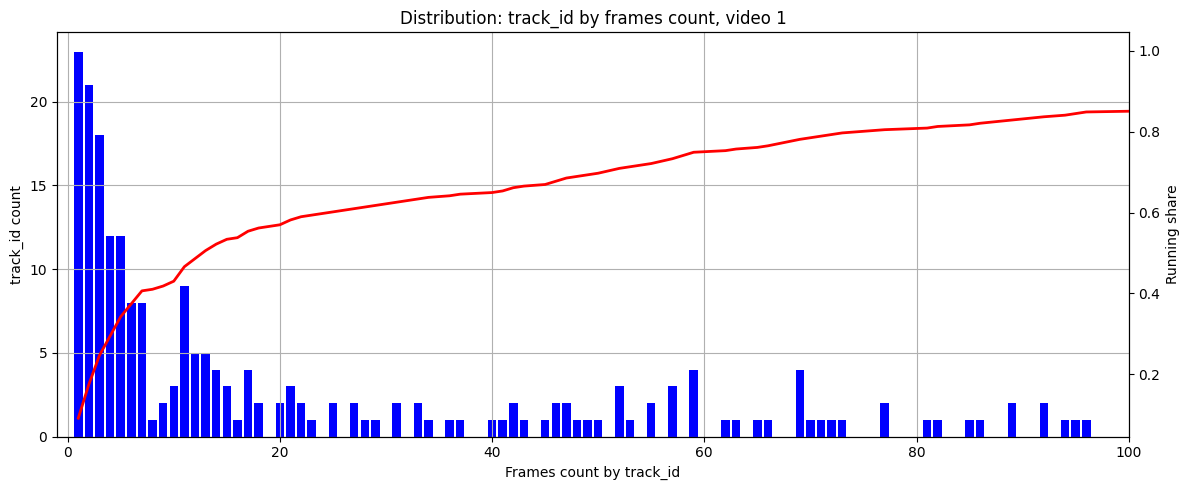

In [22]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(12, 5))

ax1.bar(vid_1_distribution['frames_count'], vid_1_distribution['ids_count'], color='blue')
ax1.set_xlabel('Frames count by track_id')
ax1.set_ylabel('track_id count')
ax1.set_xlim(-1, 100)
ax1.grid(True)

ax2 = ax1.twinx()
ax2.plot(vid_1_distribution['frames_count'], vid_1_distribution['running_share'], color='red', linewidth=2)
ax2.set_ylabel('Running share')

plt.title('Distribution: track_id by frames count, video 1')
plt.tight_layout()
plt.show()

In [23]:
vid_1_distribution[vid_1_distribution['frames_count'] >= 20].ids_count.sum()

np.int64(110)

In [24]:
vid_1_distribution.ids_count.sum()

np.int64(251)

GT содержит 90 объектов

Видео 2

In [25]:
table = pq.read_table('/video_2_df.pqt', filters=[('cls', '=', 4)], columns=['track_id', 'frame'])
df = table.to_pandas()
df['track_id'] = df['track_id'].astype('int32')
df['frame'] = df['frame'].astype('int32')

df = df.drop_duplicates()

vid_2_agg = df['track_id'].value_counts().reset_index()
vid_2_agg.columns = ['track_id', 'frames_count']

In [26]:
vid_2_distribution = vid_2_agg.groupby('frames_count', as_index=False) \
  .agg(ids_count=('track_id','nunique'))

vid_2_distribution['total_ids'] = vid_2_distribution.ids_count.sum()
vid_2_distribution['running_count'] = vid_2_distribution.ids_count.cumsum()

vid_2_distribution['running_share'] = vid_2_distribution['running_count'] / vid_2_distribution['total_ids']

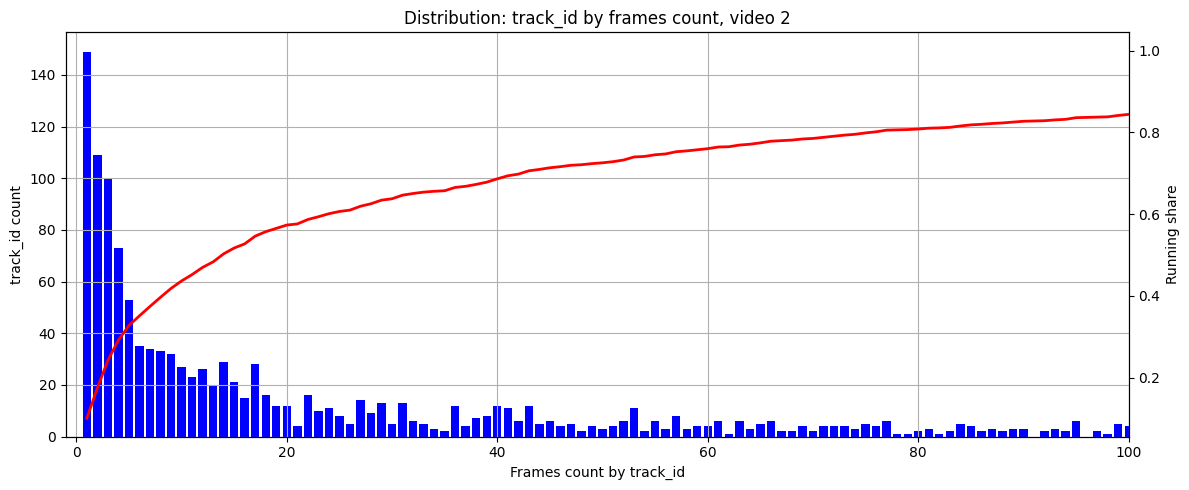

In [27]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(12, 5))

ax1.bar(vid_2_distribution['frames_count'], vid_2_distribution['ids_count'], color='blue')
ax1.set_xlabel('Frames count by track_id')
ax1.set_ylabel('track_id count')
ax1.set_xlim(-1, 100)
ax1.grid(True)

ax2 = ax1.twinx()
ax2.plot(vid_2_distribution['frames_count'], vid_2_distribution['running_share'], color='red', linewidth=2)
ax2.set_ylabel('Running share')

plt.title('Distribution: track_id by frames count, video 2')
plt.tight_layout()
plt.show()

In [31]:
vid_2_distribution[vid_2_distribution['frames_count'] >= 20].ids_count.sum()

np.int64(642)

In [29]:
vid_2_distribution.ids_count.sum()

np.int64(1477)

GT содержит 296 объектов

Видео 3

In [1]:
import pyarrow.parquet as pq
import pandas as pd

table = pq.read_table('/content/video_3_df.pqt', filters=[('cls', '=', 4)], columns=['track_id', 'frame'])
df = table.to_pandas()
df['track_id'] = df['track_id'].astype('int32')
df['frame'] = df['frame'].astype('int32')

df = df.drop_duplicates()

vid_3_agg = df['track_id'].value_counts().reset_index()
vid_3_agg.columns = ['track_id', 'frames_count']

In [18]:
vid_3_distribution = vid_3_agg.groupby('frames_count', as_index=False) \
  .agg(ids_count=('track_id','nunique'))

vid_3_distribution['total_ids'] = vid_3_distribution.ids_count.sum()
vid_3_distribution['running_count'] = vid_3_distribution.ids_count.cumsum()

vid_3_distribution['running_share'] = vid_3_distribution['running_count'] / vid_3_distribution['total_ids']

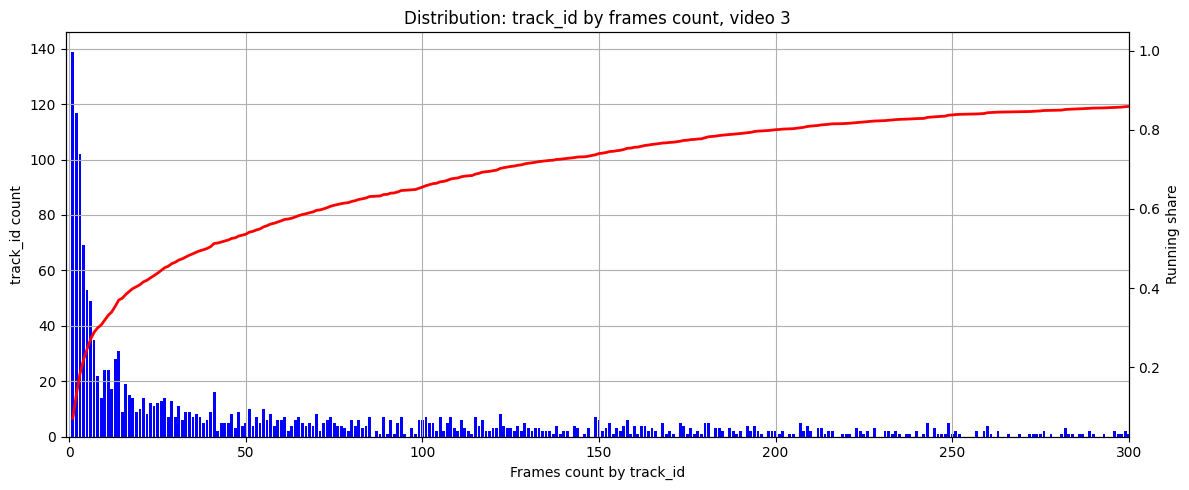

In [16]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(12, 5))

ax1.bar(vid_3_distribution['frames_count'], vid_3_distribution['ids_count'], color='blue')
ax1.set_xlabel('Frames count by track_id')
ax1.set_ylabel('track_id count')
ax1.set_xlim(-1, 300)
ax1.grid(True)

ax2 = ax1.twinx()
ax2.plot(vid_3_distribution['frames_count'], vid_3_distribution['running_share'], color='red', linewidth=2)
ax2.set_ylabel('Running share')

plt.title('Distribution: track_id by frames count, video 3')
plt.tight_layout()
plt.show()

In [17]:
vid_3_distribution.ids_count.sum()

np.int64(1958)

GT содержит 735 объектов

### Эксперименты с трекингом
Параметры по умолчанию детектируют в 2Х больше уникальных id по сравнению с GT

In [4]:
import shutil
shutil.rmtree('/content/runs/detect/mot20-train-2-local', ignore_errors=True)

In [68]:
# !cp /usr/local/lib/python3.11/dist-packages/ultralytics/cfg/trackers/bytetrack.yaml /content/

In [5]:
for train_video_id in [2]:
    input_video = f'/content/MOT20-0{train_video_id}.mp4'

    results = model.track(
        source=input_video,
        tracker='/content/bytetrack.yaml',
        # tracker='bytetrack.yaml',
        save=True,
        save_txt=True,
        conf=0.3,
        iou=0.5,
        name=f'mot20-train-{train_video_id}-local',
        stream=False
    )

    print(f'Tracking id done for: MOT20-0{train_video_id}')


WARNING ⚠️ 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/2782) /content/MOT20-02.mp4: 544x960 24 persons, 1 truck, 102.4ms
video 1/1 (frame 2/2782) /content/MOT20-02.mp4: 544x960 24 persons, 1 truck, 87.5ms
video 1/1 (frame 3/2782) /content/MOT20-02.mp4: 544x960 24 persons, 85.8ms
video 1/1 (frame 4/2782) /content/MOT20-02.mp4: 544x960 25 persons, 86.6ms
video 1/1 (frame 5/2782) /content/MOT20-02.mp4: 544x960 26 persons, 86.5ms
video 1/1 (frame 6/2782) /content/MOT20-02.mp4: 544x960 25 per

In [6]:
import pandas as pd

# video_ids = [1, 2, 3, 5]
video_ids = [2]
all_dfs = []
final_df = pd.DataFrame()


for video_id in video_ids:
  labels_dir = f'runs/detect/mot20-train-{video_id}-local/labels'
  all_data = []

  for filename in sorted(os.listdir(labels_dir)):
      if filename.endswith('.txt'):
          if '_' in filename:
            try:
                frame_id = int(filename.replace('.txt', '').split('_')[-1])
            except ValueError:
                print(f'Frame id is incorrect: {filename}')
                continue

          filepath = os.path.join(labels_dir, filename)

          with open(filepath, 'r') as f:
              for line in f:
                  cls, x_center, y_center, width, height, track_id = map(float, line.strip().split())
                  all_data.append({
                      'video_id': video_id,
                      'frame': frame_id,
                      'cls': int(cls),
                      'x_center': x_center,
                      'y_center': y_center,
                      'width': width,
                      'height': height,
                      'track_id': int(track_id)
                  })
      df = pd.DataFrame(all_data)
      all_dfs.append(df)
  print(f'video {video_id} is done')


final_df = pd.concat(all_dfs, ignore_index=True)
final_df.head()

video 2 is done


,video_id,frame,cls,x_center,y_center,width,height,track_id
0,2,1,4,0.766752,0.300071,0.039978,0.179144,1
1,2,1,4,0.272552,0.224171,0.037006,0.177292,2
2,2,1,4,0.312741,0.236902,0.035067,0.182745,3
3,2,1,4,0.377044,0.296087,0.039660,0.155865,4
4,2,1,4,0.486254,0.242964,0.035798,0.183116,5


In [7]:
final_df.to_parquet('video_2_df-local.pqt')

In [8]:
import pyarrow.parquet as pq
import pandas as pd

table = pq.read_table('/content/video_2_df-local.pqt', filters=[('cls', '=', 4)], columns=['track_id', 'frame'])
df = table.to_pandas()
df['track_id'] = df['track_id'].astype('int32')
df['frame'] = df['frame'].astype('int32')

df = df.drop_duplicates()

vid_2_agg_buffer = df['track_id'].value_counts().reset_index()
vid_2_agg_buffer.columns = ['track_id', 'frames_count']

In [9]:
vid_2_distribution_buffer = vid_2_agg_buffer.groupby('frames_count', as_index=False) \
  .agg(ids_count=('track_id','nunique'))

vid_2_distribution_buffer['total_ids'] = vid_2_distribution_buffer.ids_count.sum()
vid_2_distribution_buffer['running_count'] = vid_2_distribution_buffer.ids_count.cumsum()

vid_2_distribution_buffer['running_share'] = vid_2_distribution_buffer['running_count'] \
  / vid_2_distribution_buffer['total_ids']

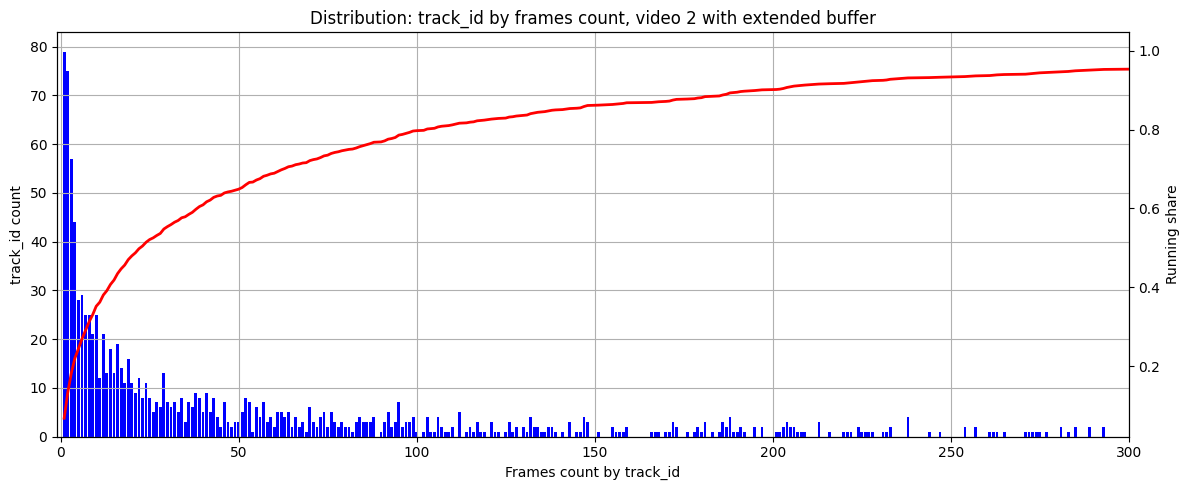

In [10]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(12, 5))

ax1.bar(vid_2_distribution_buffer['frames_count'], vid_2_distribution_buffer['ids_count'], color='blue')
ax1.set_xlabel('Frames count by track_id')
ax1.set_ylabel('track_id count')
ax1.set_xlim(-1, 300)
ax1.grid(True)

ax2 = ax1.twinx()
ax2.plot(vid_2_distribution_buffer['frames_count'], vid_2_distribution_buffer['running_share'], color='red', linewidth=2)
ax2.set_ylabel('Running share')

plt.title('Distribution: track_id by frames count, video 2 with extended buffer')
plt.tight_layout()
plt.show()

In [11]:
vid_2_distribution_buffer.ids_count.sum()

np.int64(1159)

In [13]:
vid_2_distribution_buffer[vid_2_distribution_buffer['frames_count'] > 5].ids_count.sum()

np.int64(876)

In [79]:
with open('/usr/local/lib/python3.11/dist-packages/ultralytics/cfg/trackers/bytetrack.yaml') as f:
    print(f.read())


# Ultralytics 🚀 AGPL-3.0 License - https://ultralytics.com/license

# Default Ultralytics settings for ByteTrack tracker when using mode="track"
# For documentation and examples see https://docs.ultralytics.com/modes/track/
# For ByteTrack source code see https://github.com/ifzhang/ByteTrack

tracker_type: bytetrack # tracker type, ['botsort', 'bytetrack']
track_high_thresh: 0.25 # threshold for the first association
track_low_thresh: 0.1 # threshold for the second association
new_track_thresh: 0.25 # threshold for init new track if the detection does not match any tracks
track_buffer: 30 # buffer to calculate the time when to remove tracks
match_thresh: 0.8 # threshold for matching tracks
fuse_score: True # Whether to fuse confidence scores with the iou distances before matching
# min_box_area: 10  # threshold for min box areas(for tracker evaluation, not used for now)



Аппендикс

Чтобы run_mot_challenge.py заработал в google collab (а может и не только)
нужно добавить в него код

```
args = parser.parse_args().__dict__

##### этот участок #####

for setting in ['SEQMAP_FILE', 'BENCHMARK', 'SPLIT_TO_EVAL', 'GT_FOLDER', 'TRACKERS_FOLDER']:
      if setting in args and isinstance(args[setting], list) and len(args[setting]) == 1:
        args[setting] = args[setting][0]

#########################

for setting in args.keys():
        if args[setting] is not None:
            if type(config[setting]) == type(True):

```

Архивирование и скачивание лейблов

In [14]:
!zip -r mot20-train-2-custom_bytetrack_labels.zip /content/runs/detect/mot20-train-2-local/labels
from google.colab import files
files.download('mot20-train-2-custom_bytetrack_labels.zip')

  adding: content/runs/detect/mot20-train-2-local/labels/ (stored 0%)
  adding: content/runs/detect/mot20-train-2-local/labels/MOT20-02_821.txt (deflated 56%)
  adding: content/runs/detect/mot20-train-2-local/labels/MOT20-02_2387.txt (deflated 56%)
  adding: content/runs/detect/mot20-train-2-local/labels/MOT20-02_879.txt (deflated 56%)
  adding: content/runs/detect/mot20-train-2-local/labels/MOT20-02_1414.txt (deflated 57%)
  adding: content/runs/detect/mot20-train-2-local/labels/MOT20-02_360.txt (deflated 57%)
  adding: content/runs/detect/mot20-train-2-local/labels/MOT20-02_1102.txt (deflated 56%)
  adding: content/runs/detect/mot20-train-2-local/labels/MOT20-02_1796.txt (deflated 57%)
  adding: content/runs/detect/mot20-train-2-local/labels/MOT20-02_2210.txt (deflated 56%)
  adding: content/runs/detect/mot20-train-2-local/labels/MOT20-02_1060.txt (deflated 56%)
  adding: content/runs/detect/mot20-train-2-local/labels/MOT20-02_1803.txt (deflated 57%)
  adding: content/runs/detect/mot

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>